In [51]:
#Data Generation Logic

import pandas as pd
import numpy as np
from datetime import datetime, timedelta


NUM_RECORDS = 50000
FILENAME = 'nova_custom_biased_dataset.csv'
np.random.seed(42) 

def calculate_loyalty_score(partner_since_date, trip_frequency):
    """Creates a loyalty score normalized to [0, 1]."""
    days_as_partner = (datetime.now() - partner_since_date).days
    tenure_score = 1 - np.exp(-days_as_partner / 1000)  
    trips_score = 1 - np.exp(-trip_frequency / 200)      
    return round(0.6 * tenure_score + 0.4 * trips_score, 3)

data = []
partner_types = ['Driver', 'Merchant']
driver_vehicle_types = ['Cab Driver', 'Food Delivery Rider']
merchant_categories = ['Small', 'Medium', 'Large']

for i in range(NUM_RECORDS):
    gender = np.random.choice(['Male', 'Female'], p=[0.85, 0.15])
    partner_type = np.random.choice(partner_types, p=[0.7, 0.3])
    
    record = {'gender': gender, 'partner_type': partner_type}
    
    if partner_type == 'Driver':
        record['vehicle_type'] = np.random.choice(driver_vehicle_types, p=[0.6, 0.4])
        days_ago = np.random.randint(30, 365 * 4)
        record['partner_since_date'] = datetime.now() - timedelta(days=days_ago)
        record['geographic_location'] = np.random.choice(['Urban', 'Rural'], p=[0.75, 0.25])
        
        if record['geographic_location'] == 'Urban':
            record['shift'] = np.random.choice(['Day', 'Night'], p=[0.4, 0.6])
        else:
            record['shift'] = np.random.choice(['Day', 'Night'], p=[0.8, 0.2])
        
        if record['vehicle_type'] == 'Cab Driver':
            base_rate_range = (18, 25)
        else:
            base_rate_range = (12, 18)

        if record['geographic_location'] == 'Rural':
            base_rate_range = tuple(x * 0.8 for x in base_rate_range)

        if gender == 'Female':
            base_rate_range = tuple(x * 0.9 for x in base_rate_range)

        if record['shift'] == 'Night':
            base_rate_range = tuple(x * 1.2 for x in base_rate_range)

        hours_online = np.random.uniform(100, 250)
        earnings_per_hour = round(np.random.uniform(*base_rate_range), 2)
        total_earnings = hours_online * earnings_per_hour

        record['earnings_per_hour'] = earnings_per_hour
        record['total_earnings'] = round(total_earnings, 2)
        record['hours_online'] = int(round(hours_online, 0))

        trip_freq = np.random.uniform(80, 200)
        if record['geographic_location'] == 'Rural':
            trip_freq *= 0.9
        record['trip_frequency'] = int(round(trip_freq, 0))

        record['num_insurance_claims'] = np.random.choice([0, 1, 2, 3, 4, 5], p=[0.7, 0.15, 0.05, 0.05, 0.025, 0.025])
        
        if record['num_insurance_claims'] <= 1:
            rating = np.random.uniform(4.5, 5.0) 
        elif record['num_insurance_claims'] <= 3:
            rating = np.random.uniform(4.0, 4.7)
        else:
            rating = np.random.uniform(3.5, 4.2) 
        record['customer_rating'] = round(rating, 1)

        weekly_earnings = np.random.normal(
            loc=total_earnings / 4, 
            scale=total_earnings / 20, 
            size=12
        )
        record['consistency_index'] = round(np.std(weekly_earnings), 2)

        record['loyalty_score'] = calculate_loyalty_score(record['partner_since_date'], trip_freq)
    
    #Merchants
    else:
        record['merchant_category'] = np.random.choice(merchant_categories, p=[0.6, 0.3, 0.1])
        record['geographic_location'] = np.random.choice(['Urban', 'Rural'], p=[0.8, 0.2])
        
        if record['merchant_category'] == 'Small':
            base_gmv = np.random.uniform(50_000, 150_000)
        elif record['merchant_category'] == 'Medium':
            base_gmv = np.random.uniform(200_000, 500_000)
        else:
            base_gmv = np.random.uniform(600_000, 2_000_000)
        
        gmv = base_gmv
        if gender == 'Female':
            gmv *= 0.9
        if record['geographic_location'] == 'Rural':
            gmv *= 0.7
            
        record['gross_merchandise_volume'] = round(gmv, 2)
        record['average_order_value'] = round(gmv / np.random.randint(500, 5000), 2)
        record['sales_growth'] = round(np.random.uniform(-0.05, 0.20), 2)

        monthly_revenues = []
        for _ in range(12):
            month_rev = gmv / 12 * np.random.uniform(0.8, 1.2)
            monthly_revenues.append(month_rev)
        coef_var = np.std(monthly_revenues) / np.mean(monthly_revenues)
        record['revenue_stability_score'] = round(1 - min(coef_var / 0.6, 1), 2)

        record['store_availability'] = round(np.random.uniform(0.85, 1.0), 2)
        record['preparation_speed'] = round(np.random.uniform(10, 25), 1)
        record['order_accuracy'] = round(np.random.uniform(0.95, 1.0), 3)
        record['customer_retention'] = round(np.random.uniform(0.4, 0.8), 2)
    
    data.append(record)

df = pd.DataFrame(data)
df.to_csv(FILENAME, index=False)

print(f"Successfully generated biased dataset with {len(df)} records.")
print(f"File saved as '{FILENAME}'")

print("\n--- Verifying Biases ---")
print("Avg Earnings Per Hour by Gender (Drivers):")
print(df[df['partner_type'] == 'Driver'].groupby('gender')['earnings_per_hour'].mean().round(2))
print("\nAvg Earnings Per Hour by Location (Drivers):")
print(df[df['partner_type'] == 'Driver'].groupby('geographic_location')['earnings_per_hour'].mean().round(2))
print("\nAvg GMV by Location (Merchants):")
print(df[df['partner_type'] == 'Merchant'].groupby('geographic_location')['gross_merchandise_volume'].mean().round(2))

print("\nSample:")
display(df.head())


Successfully generated biased dataset with 50000 records.
File saved as 'nova_custom_biased_dataset.csv'

--- Verifying Biases ---
Avg Earnings Per Hour by Gender (Drivers):
gender
Female    17.88
Male      19.88
Name: earnings_per_hour, dtype: float64

Avg Earnings Per Hour by Location (Drivers):
geographic_location
Rural    15.56
Urban    20.91
Name: earnings_per_hour, dtype: float64

Avg GMV by Location (Merchants):
geographic_location
Rural    202403.53
Urban    287205.88
Name: gross_merchandise_volume, dtype: float64

Sample:


,gender,partner_type,merchant_category,geographic_location,gross_merchandise_volume,average_order_value,sales_growth,revenue_stability_score,store_availability,preparation_speed,...,partner_since_date,shift,earnings_per_hour,total_earnings,hours_online,trip_frequency,num_insurance_claims,customer_rating,consistency_index,loyalty_score
0,Male,Merchant,Medium,Urban,246805.59,255.49,-0.03,0.77,0.85,17.9,...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,2022-12-03 14:44:46.385096,Night,19.79,3737.58,189.0,153.0,0.0,4.5,130.46,0.590
2,Male,Driver,NaN,Rural,NaN,NaN,NaN,NaN,NaN,NaN,...,2023-08-15 14:44:46.386108,Day,19.59,3120.15,159.0,151.0,0.0,4.8,175.39,0.523
3,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-06-21 14:44:46.387100,Night,24.61,2734.34,111.0,94.0,2.0,4.4,119.83,0.356
4,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,2022-09-13 14:44:46.387100,Night,29.12,3793.11,130.0,137.0,0.0,4.8,153.07,0.592


In [52]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Block 1: Data Prep & PCA for MoE

try:
    df = pd.read_csv('nova_custom_biased_dataset.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'nova_custom_biased_dataset.csv' not found.")
    df = None

if df is not None:
    df_drivers = df[df['partner_type'] == 'Driver'].copy()
    df_merchants = df[df['partner_type'] == 'Merchant'].copy()
    
    print("\nProcessing Driver data...")
    driver_features = [
        'earnings_per_hour', 'total_earnings', 'hours_online', 'trip_frequency',
        'num_insurance_claims', 'customer_rating', 'consistency_index', 'loyalty_score'
    ]
    df_drivers_perf = df_drivers[driver_features].fillna(0)
    
    scaler_driver = StandardScaler()
    drivers_scaled = scaler_driver.fit_transform(df_drivers_perf)
    pca_driver = PCA(n_components=3, random_state=42)
    drivers_pca = pca_driver.fit_transform(drivers_scaled)
    df_drivers_pca = pd.DataFrame(drivers_pca, columns=['PC1', 'PC2', 'PC3'], index=df_drivers.index)
    print("✅ Drivers PCA complete.")

    print("Processing Merchant data...")
    merchant_features = [
        'gross_merchandise_volume', 'average_order_value', 'sales_growth',
        'revenue_stability_score', 'store_availability', 'preparation_speed',
        'order_accuracy', 'customer_retention'
    ]
    df_merchants_perf = df_merchants[merchant_features].fillna(0)

    scaler_merchant = StandardScaler()
    merchants_scaled = scaler_merchant.fit_transform(df_merchants_perf)
    pca_merchant = PCA(n_components=3, random_state=42)
    merchants_pca = pca_merchant.fit_transform(merchants_scaled)
    df_merchants_pca = pd.DataFrame(merchants_pca, columns=['PC1', 'PC2', 'PC3'], index=df_merchants.index)
    print("✅ Merchants PCA complete.")

    df_pca_combined = pd.concat([df_drivers_pca, df_merchants_pca])
    
    df_pca_combined = df_pca_combined.join(df['partner_type'])

    print("\n--- Sample of the Combined DataFrame after PCA ---")
    display(df_pca_combined.head())

Dataset loaded successfully.

Processing Driver data...
✅ Drivers PCA complete.
Processing Merchant data...
✅ Merchants PCA complete.

--- Sample of the Combined DataFrame after PCA ---


,PC1,PC2,PC3,partner_type
1,0.108844,-0.041981,0.854457,Driver
2,-0.126752,0.724592,0.532188,Driver
3,-0.959567,-1.490324,-1.215135,Driver
4,0.543560,0.713020,0.857363,Driver
5,-0.979427,0.482020,-0.508081,Driver


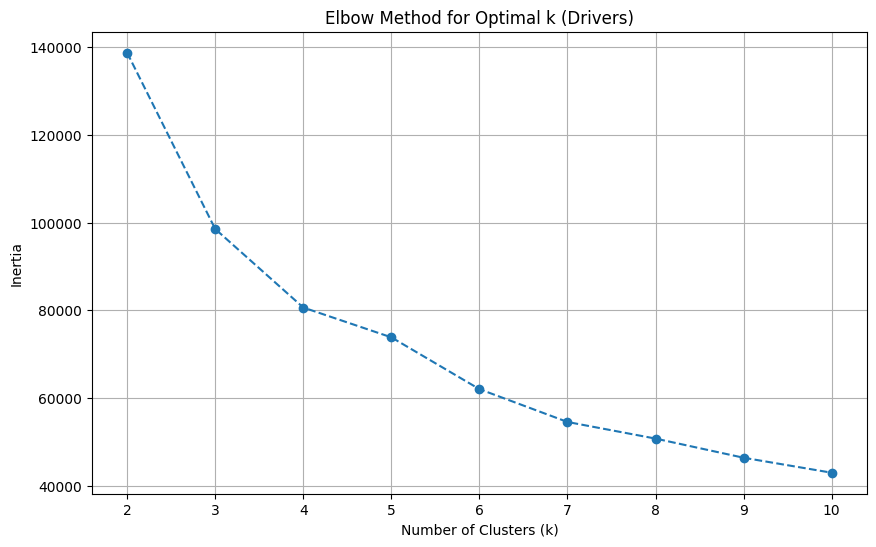

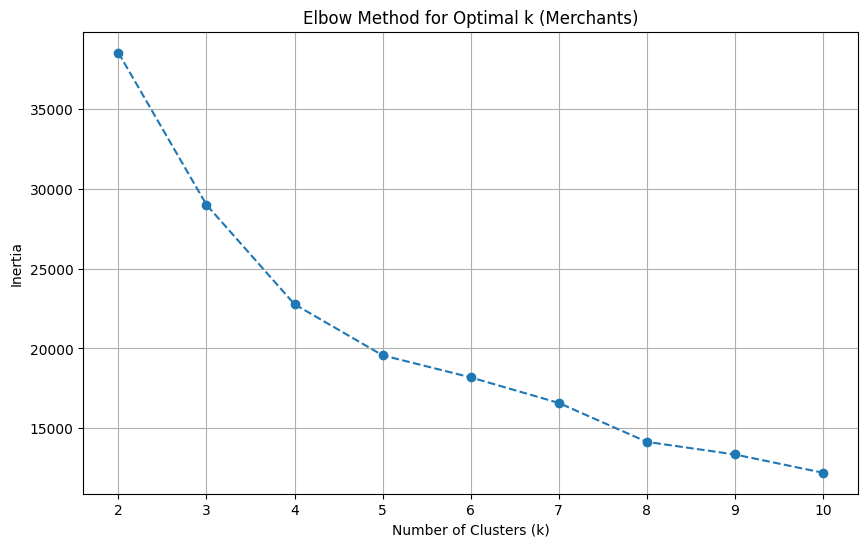

In [53]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import warnings

#Block 2:Optimal k

warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.cluster._kmeans')

if 'df_drivers_pca' in locals() and 'df_merchants_pca' in locals():
    
    inertia_drivers = []
    k_range = range(2, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(df_drivers_pca)
        inertia_drivers.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia_drivers, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k (Drivers)')
    plt.xticks(k_range)
    plt.grid(True)
    plt.savefig('elbow_plot_drivers.png')
    plt.show()

    inertia_merchants = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(df_merchants_pca)
        inertia_merchants.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia_merchants, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal k (Merchants)')
    plt.xticks(k_range)
    plt.grid(True)
    plt.savefig('elbow_plot_merchants.png')
    plt.show()

else:
    print("Please run the PCA block first to generate the necessary data.")

For Drivers, k=2, the average silhouette_score is : 0.3107
For Drivers, k=3, the average silhouette_score is : 0.3520
For Drivers, k=4, the average silhouette_score is : 0.2959
For Drivers, k=5, the average silhouette_score is : 0.2938
For Drivers, k=6, the average silhouette_score is : 0.2869
For Drivers, k=7, the average silhouette_score is : 0.2716
For Drivers, k=8, the average silhouette_score is : 0.2773
For Drivers, k=9, the average silhouette_score is : 0.2725
For Drivers, k=10, the average silhouette_score is : 0.2666


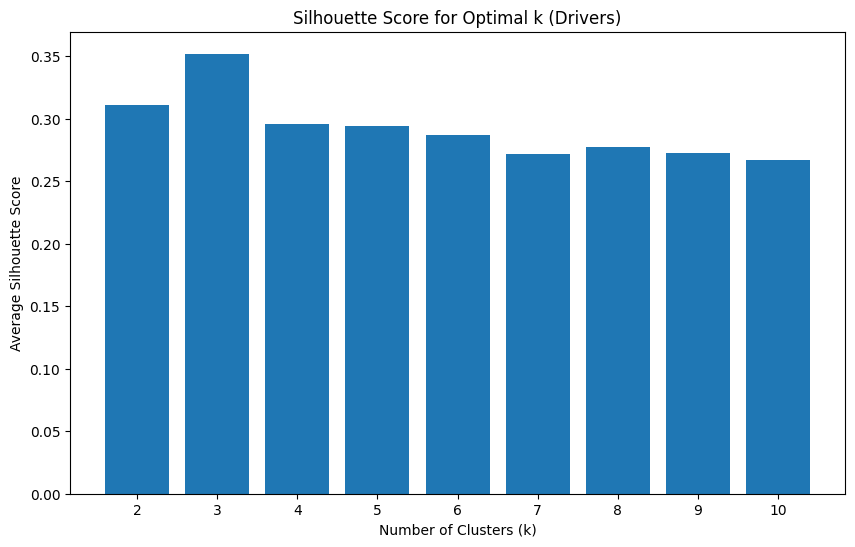



For Merchants, k=2, the average silhouette_score is : 0.5533
For Merchants, k=3, the average silhouette_score is : 0.2799
For Merchants, k=4, the average silhouette_score is : 0.2847
For Merchants, k=5, the average silhouette_score is : 0.2670
For Merchants, k=6, the average silhouette_score is : 0.2419
For Merchants, k=7, the average silhouette_score is : 0.2580
For Merchants, k=8, the average silhouette_score is : 0.2613
For Merchants, k=9, the average silhouette_score is : 0.2514
For Merchants, k=10, the average silhouette_score is : 0.2543


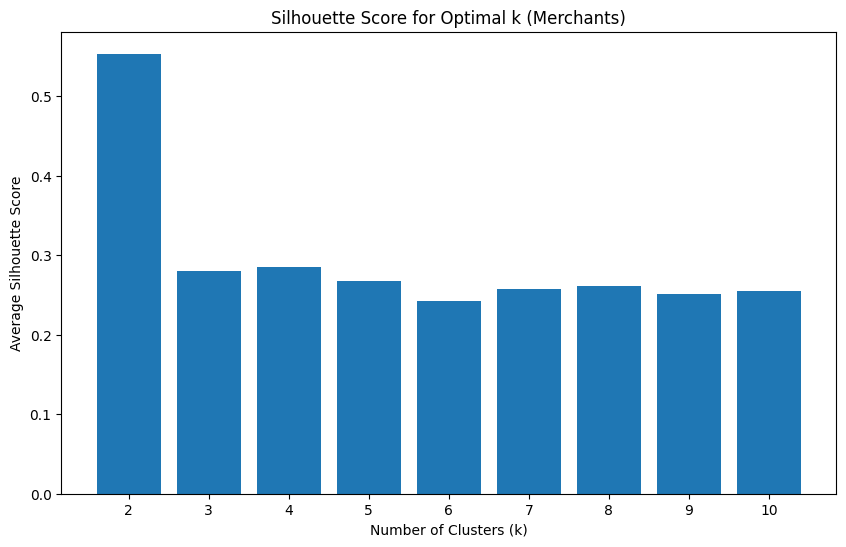

In [54]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import warnings

#Block 3: Silhouette Score for Optimal k

warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.cluster._kmeans')

if 'df_drivers_pca' in locals() and 'df_merchants_pca' in locals():
    
    silhouette_scores_drivers = []
    k_range = range(2, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        cluster_labels = kmeans.fit_predict(df_drivers_pca)
        silhouette_avg = silhouette_score(df_drivers_pca, cluster_labels)
        silhouette_scores_drivers.append(silhouette_avg)
        print(f"For Drivers, k={k}, the average silhouette_score is : {silhouette_avg:.4f}")

    plt.figure(figsize=(10, 6))
    plt.bar(k_range, silhouette_scores_drivers)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Score for Optimal k (Drivers)')
    plt.xticks(k_range)
    plt.savefig('silhouette_plot_drivers.png')
    plt.show()

    print("\n" + "="*50 + "\n")
    silhouette_scores_merchants = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        cluster_labels = kmeans.fit_predict(df_merchants_pca)
        silhouette_avg = silhouette_score(df_merchants_pca, cluster_labels)
        silhouette_scores_merchants.append(silhouette_avg)
        print(f"For Merchants, k={k}, the average silhouette_score is : {silhouette_avg:.4f}")
        
    plt.figure(figsize=(10, 6))
    plt.bar(k_range, silhouette_scores_merchants)
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Average Silhouette Score')
    plt.title('Silhouette Score for Optimal k (Merchants)')
    plt.xticks(k_range)
    plt.savefig('silhouette_plot_merchants.png')
    plt.show()

else:
    print("Please run the PCA block first to generate the necessary data.")

In [55]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import warnings

# Block 4: Algorithm Comparison (with optimal k)

warnings.filterwarnings('ignore', category=FutureWarning, module='sklearn.cluster._kmeans')

if 'df_pca_combined' in locals() and 'df' in locals():
    k_drivers = 3  
    k_merchants = 2 
    
    print(f"Proceeding with k={k_drivers} for Drivers and k={k_merchants} for Merchants.")
    
    df_drivers_pca = df_pca_combined[df_pca_combined['partner_type'] == 'Driver'][['PC1', 'PC2', 'PC3']]
    df_merchants_pca = df_pca_combined[df_pca_combined['partner_type'] == 'Merchant'][['PC1', 'PC2', 'PC3']]
    
    print("\n Running K-Means")
    kmeans_drivers = KMeans(n_clusters=k_drivers, random_state=42, n_init='auto').fit_predict(df_drivers_pca)
    kmeans_merchants = KMeans(n_clusters=k_merchants, random_state=42, n_init='auto').fit_predict(df_merchants_pca)
    df['kmeans_cluster'] = pd.concat([pd.Series(kmeans_drivers, index=df_drivers_pca.index), pd.Series(kmeans_merchants, index=df_merchants_pca.index)]).astype(int)
    display(df.groupby('partner_type')['kmeans_cluster'].value_counts().to_frame())
    
    print("\n Running Hierarchical Clustering")
    agg_drivers = AgglomerativeClustering(n_clusters=k_drivers).fit_predict(df_drivers_pca)
    agg_merchants = AgglomerativeClustering(n_clusters=k_merchants).fit_predict(df_merchants_pca)
    df['agg_cluster'] = pd.concat([pd.Series(agg_drivers, index=df_drivers_pca.index), pd.Series(agg_merchants, index=df_merchants_pca.index)]).astype(int)
    display(df.groupby('partner_type')['agg_cluster'].value_counts().to_frame())

    print("\n Running DBSCAN Clustering")
    dbscan_drivers = DBSCAN(eps=0.5, min_samples=10).fit_predict(df_drivers_pca)
    dbscan_merchants = DBSCAN(eps=0.5, min_samples=10).fit_predict(df_merchants_pca)
    df['dbscan_cluster'] = pd.concat([pd.Series(dbscan_drivers, index=df_drivers_pca.index), pd.Series(dbscan_merchants, index=df_merchants_pca.index)]).astype(int)
    display(df.groupby('partner_type')['dbscan_cluster'].value_counts().to_frame())

else:
    print("Please run the PCA block first to generate the necessary data.")

Proceeding with k=3 for Drivers and k=2 for Merchants.

 Running K-Means


count
partner_type kmeans_cluster       
Driver       1               18520
             0               12254
             2                4081
Merchant     0               13938
             1                1207


 Running Hierarchical Clustering


count
partner_type agg_cluster       
Driver       0            17144
             1            12692
             2             5019
Merchant     0            13811
             1             1334


 Running DBSCAN Clustering


count
partner_type dbscan_cluster       
Driver        0              34440
             -1                408
              1                  7
Merchant      0              14723
             -1                408
              1                  8
              2                  6

In [56]:
# Block 5: Analyze K-Means Cluster Characteristics

if 'df' in locals() and 'kmeans_cluster' in df.columns:
    
    print("--- Analyzing Driver Cluster Profiles ---")
    driver_analysis_features = [
        'earnings_per_hour', 'customer_rating', 
        'loyalty_score', 'consistency_index', 'num_insurance_claims'
    ]
    
    driver_cluster_profiles = df[df['partner_type'] == 'Driver'].groupby('kmeans_cluster')[driver_analysis_features].mean()
    display(driver_cluster_profiles.round(2))

    print("\n--- Analyzing Merchant Cluster Profiles ---")
    merchant_analysis_features = [
        'revenue_stability_score', 'customer_retention', 
        'sales_growth', 'order_accuracy'
    ]
    
    merchant_cluster_profiles = df[df['partner_type'] == 'Merchant'].groupby('kmeans_cluster')[merchant_analysis_features].mean()
    display(merchant_cluster_profiles.round(2))

else:
    print("Please run the clustering block first to generate the 'kmeans_cluster' column.")

--- Analyzing Driver Cluster Profiles ---


,earnings_per_hour,customer_rating,loyalty_score,consistency_index,num_insurance_claims
kmeans_cluster,,,,,
0,22.99,4.74,0.49,224.83,0.28
1,17.38,4.74,0.48,118.71,0.23
2,19.27,4.08,0.48,153.05,3.44



--- Analyzing Merchant Cluster Profiles ---


,revenue_stability_score,customer_retention,sales_growth,order_accuracy
kmeans_cluster,,,,
0,0.82,0.6,0.08,0.97
1,0.82,0.6,0.07,0.97


In [57]:
# Block 5: Map Clusters to a Continuous NovaScore

if 'df' in locals() and 'kmeans_cluster' in df.columns:
    
    driver_score_map = {
        0: (8.5, 10.0),  
        1: (6.5, 8.4),   
        2: (1.0, 6.4)    
    }

    merchant_score_map = {
        0: (8.0, 10.0),  
        1: (5.0, 7.9)    
    }

    def assign_novascore(row):
        cluster = row['kmeans_cluster']
        if row['partner_type'] == 'Driver':
            score_range = driver_score_map.get(cluster, (0, 0))
        else: 
            score_range = merchant_score_map.get(cluster, (0, 0))
        
        return round(np.random.uniform(score_range[0], score_range[1]), 2)

    df['NovaScore'] = df.apply(assign_novascore, axis=1)
    
    print("✅ NovaScore assigned to all partners based on your final cluster analysis.")

    print("\n Final DataFrame with NovaScore")
    display(df[['partner_type', 'kmeans_cluster', 'NovaScore']].head(10))

else:
    print("Please run the clustering analysis block first.")


✅ NovaScore assigned to all partners based on your final cluster analysis.

 Final DataFrame with NovaScore


,partner_type,kmeans_cluster,NovaScore
0,Merchant,0,9.70
1,Driver,1,6.99
2,Driver,1,6.61
3,Driver,2,1.30
4,Driver,0,9.43
5,Driver,1,7.43
6,Driver,2,5.51
7,Driver,1,7.14
8,Driver,2,3.36
9,Driver,2,1.79


In [58]:
from fairlearn.metrics import MetricFrame

# Block 6: Bias Investigation

if 'df' in locals() and 'NovaScore' in df.columns:
    
    metrics = {'average_score': (lambda y_true, y_pred: y_pred.mean())}

    y_pred = df['NovaScore']
    y_true = df['NovaScore'] 

    # 1. Audit by Gender
    print("--- Fairness Audit by Gender ---")
    sensitive_features_gender = df['gender']
    
    grouped_on_gender = MetricFrame(metrics=metrics,
                                    y_true=y_true,
                                    y_pred=y_pred,
                                    sensitive_features=sensitive_features_gender)

    print("\nAverage NovaScore by group:")
    display(grouped_on_gender.by_group.round(2))
    
    gender_difference = grouped_on_gender.difference()
    print(f"\nDifference in average score between genders: {gender_difference['average_score']:.4f}")

    # 2. Audit by Geographic Location
    print("\n--- Fairness Audit by Geographic Location ---")
    sensitive_features_geo = df['geographic_location']

    grouped_on_geo = MetricFrame(metrics=metrics,
                                 y_true=y_true,
                                 y_pred=y_pred,
                                 sensitive_features=sensitive_features_geo)
                                 
    print("\nAverage NovaScore by group:")
    display(grouped_on_geo.by_group.round(2))

    geo_difference = grouped_on_geo.difference()
    print(f"\nDifference in average score between locations: {geo_difference['average_score']:.4f}")

else:
    print("Please run the NovaScore assignment block first.")

--- Fairness Audit by Gender ---

Average NovaScore by group:


,average_score
gender,
Female,7.86
Male,8.02



Difference in average score between genders: 0.1536

--- Fairness Audit by Geographic Location ---

Average NovaScore by group:


,average_score
geographic_location,
Rural,7.69
Urban,8.09



Difference in average score between locations: 0.3940


In [59]:
# Block 7: Prepare Data for Bias Mitigation 

from sklearn.model_selection import train_test_split

if 'df' in locals() and 'NovaScore' in df.columns:
    
    CREDIT_THRESHOLD = 5.5
    
    df['is_creditworthy'] = (df['NovaScore'] >= CREDIT_THRESHOLD).astype(int)
    
    print(f"Created binary 'is_creditworthy' prediction based on a threshold of {CREDIT_THRESHOLD}.")
    
    
    train_df_scored, test_df_scored = train_test_split(
        df,
        test_size=0.3,
        random_state=42,
        stratify=df['is_creditworthy']
    )
    
    print(f"Split data into train ({len(train_df_scored)}) and test ({len(test_df_scored)}) sets.")
    
    print("\n--- Sample of Training Data ---")
    display(train_df_scored.head())
    
    print("\n--- Sample of Test Data ---")
    display(test_df_scored.head())
    
    print("\n--- Distribution of Creditworthy Partners in Train ---")
    print(train_df_scored['is_creditworthy'].value_counts(normalize=True))
    
    print("\n--- Distribution of Creditworthy Partners in Test ---")
    print(test_df_scored['is_creditworthy'].value_counts(normalize=True))

else:
    print("Please run the NovaScore assignment block (Block 5) first.")


Created binary 'is_creditworthy' prediction based on a threshold of 5.5.
Split data into train (35000) and test (15000) sets.

--- Sample of Training Data ---


,gender,partner_type,merchant_category,geographic_location,gross_merchandise_volume,average_order_value,sales_growth,revenue_stability_score,store_availability,preparation_speed,...,trip_frequency,num_insurance_claims,customer_rating,consistency_index,loyalty_score,kmeans_cluster,agg_cluster,dbscan_cluster,NovaScore,is_creditworthy
32736,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,168.0,3.0,4.7,132.64,0.355,1,1,0,8.27,1
39834,Male,Merchant,Small,Urban,147599.07,37.62,0.06,0.81,0.86,19.1,...,NaN,NaN,NaN,NaN,NaN,0,0,0,8.90,1
45869,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,137.0,0.0,4.9,103.48,0.602,1,1,0,7.67,1
25483,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,87.0,0.0,4.9,132.89,0.240,1,0,0,7.90,1
40230,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,176.0,0.0,4.9,192.09,0.693,0,0,0,8.60,1



--- Sample of Test Data ---


,gender,partner_type,merchant_category,geographic_location,gross_merchandise_volume,average_order_value,sales_growth,revenue_stability_score,store_availability,preparation_speed,...,trip_frequency,num_insurance_claims,customer_rating,consistency_index,loyalty_score,kmeans_cluster,agg_cluster,dbscan_cluster,NovaScore,is_creditworthy
10138,Male,Driver,NaN,Rural,NaN,NaN,NaN,NaN,NaN,NaN,...,83.0,0.0,4.9,107.56,0.561,1,1,0,7.41,1
558,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,114.0,0.0,4.8,80.24,0.491,1,0,0,8.14,1
18256,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,98.0,0.0,4.7,143.25,0.494,1,0,0,8.12,1
47938,Male,Merchant,Medium,Urban,440763.1,262.83,0.18,0.82,0.93,17.7,...,NaN,NaN,NaN,NaN,NaN,0,0,0,8.03,1
45764,Male,Driver,NaN,Urban,NaN,NaN,NaN,NaN,NaN,NaN,...,134.0,0.0,4.6,229.54,0.450,0,0,0,9.41,1



--- Distribution of Creditworthy Partners in Train ---
is_creditworthy
1    0.928029
0    0.071971
Name: proportion, dtype: float64

--- Distribution of Creditworthy Partners in Test ---
is_creditworthy
1    0.928067
0    0.071933
Name: proportion, dtype: float64


In [60]:
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import numpy as np

#  Block 8: Bias Mitigation with Intersectional Sensitive Features

if 'train_df_scored' in locals() and 'test_df_scored' in locals():
    print("--- Mitigating Bias based on: gender + geographic_location ---")

    train_df_scored['gender_location'] = train_df_scored['gender'] + "_" + train_df_scored['geographic_location']
    test_df_scored['gender_location'] = test_df_scored['gender'] + "_" + test_df_scored['geographic_location']
    SENSITIVE_FEATURE = 'gender_location'
    
    X_train = train_df_scored[['NovaScore']] 
    X_test = test_df_scored[['NovaScore']]
    y_train_true = train_df_scored['is_creditworthy']
    y_test_true = test_df_scored['is_creditworthy']
    sensitive_features_train = train_df_scored[SENSITIVE_FEATURE]
    sensitive_features_test = test_df_scored[SENSITIVE_FEATURE]

    
    base_estimator = CalibratedClassifierCV(
        LogisticRegression(max_iter=500, solver='liblinear'),
        method='sigmoid',
        cv=5
    )
    base_estimator.fit(X_train, y_train_true)
    
    optimizer = ThresholdOptimizer(
        estimator=base_estimator,
        constraints="demographic_parity",
        prefit=True 
    )
    optimizer.fit(
        X_train, y_train_true,
        sensitive_features=sensitive_features_train
    )
    print("Fairness optimizer trained successfully.")
    
    original_pred = base_estimator.predict(X_test)
    mitigated_pred = optimizer.predict(
        X_test,
        sensitive_features=sensitive_features_test
    )
    
    metrics = {"selection_rate": lambda y_true, y_pred: y_pred.mean()}
    before_audit = MetricFrame(
        metrics=metrics,
        y_true=y_test_true,
        y_pred=original_pred,
        sensitive_features=sensitive_features_test
    )
    after_audit = MetricFrame(
        metrics=metrics,
        y_true=y_test_true,
        y_pred=mitigated_pred,
        sensitive_features=sensitive_features_test
    )
    
    print("\n--- Fairness Audit BEFORE Mitigation ---")
    display(before_audit.by_group)
    print(f"Disparity BEFORE: {before_audit.difference()['selection_rate']:.4f}")
    
    print("\n--- Fairness Audit AFTER Mitigation ---")
    display(after_audit.by_group)
    print(f"Disparity AFTER: {after_audit.difference()['selection_rate']:.4f}")

else:
    print("Please run the mitigation preparation block (Block 7) first.")

--- Mitigating Bias based on: gender + geographic_location ---
Fairness optimizer trained successfully.

--- Fairness Audit BEFORE Mitigation ---


,selection_rate
gender_location,
Female_Rural,0.913669
Female_Urban,0.931805
Male_Rural,0.923924
Male_Urban,0.929499


Disparity BEFORE: 0.0181

--- Fairness Audit AFTER Mitigation ---


,selection_rate
gender_location,
Female_Rural,0.933453
Female_Urban,0.935817
Male_Rural,0.925259
Male_Urban,0.929499


Disparity AFTER: 0.0106


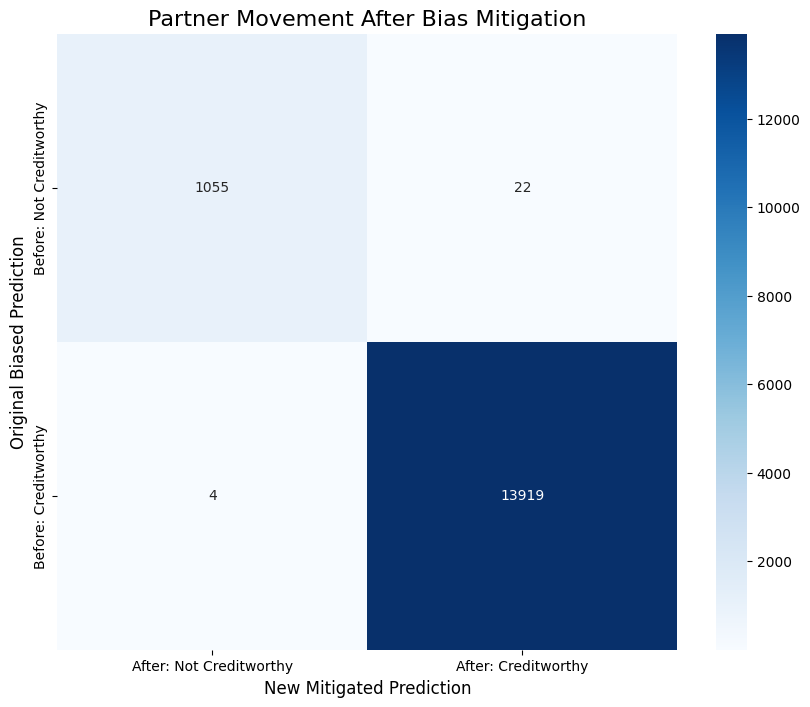


✅ Analysis Complete:
- 22 partners were upgraded from 'Not Creditworthy' to 'Creditworthy'.
- 4 partners were downgraded to achieve fairness.


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Final Block: Visualize Mitigation Impact

if 'original_predictions' in locals() and 'mitigated_predictions' in locals():
    
    movement_matrix = confusion_matrix(original_predictions, mitigated_predictions)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(movement_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['After: Not Creditworthy', 'After: Creditworthy'],
                yticklabels=['Before: Not Creditworthy', 'Before: Creditworthy'])
    
    plt.title('Partner Movement After Bias Mitigation', fontsize=16)
    plt.ylabel('Original Biased Prediction', fontsize=12)
    plt.xlabel('New Mitigated Prediction', fontsize=12)
    plt.savefig('mitigation_impact_matrix.png')
    plt.show()

    upgraded_count = movement_matrix[0, 1]
    downgraded_count = movement_matrix[1, 0]
    
    print(f"\n✅ Analysis Complete:")
    print(f"- {upgraded_count} partners were upgraded from 'Not Creditworthy' to 'Creditworthy'.")
    print(f"- {downgraded_count} partners were downgraded to achieve fairness.")

else:
    print("Please run the bias mitigation block first to generate the predictions.")